In [3]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from prosit_t.eval import prosit_transformer_eval
import wandb
import tensorflow as tf
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import os
from prosit_t.data.parquet_to_tfdataset import get_tfdatasets
from prosit_t.models import PrositTransformerV2, ProstTransformerDynamicLen
import pandas as pd
from dlomix.models import PrositIntensityPredictor

In [5]:
pio.renderers.default = "iframe"

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
batch_size = 1024

In [ ]:
_, val_data = get_tfdatasets(batch_size=batch_size, encode_ox=False)

In [ ]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-glorious-dawn-885:v94"
transformer = ProstTransformerDynamicLen(embedding_output_dim=64,num_heads=16,meta_embedding_dim=256,
        num_transformers=6)
transformer = prosit_transformer_eval.load_model(run,artifact_path,transformer)

In [ ]:
data_list = prosit_transformer_eval.dataset_to_list(val_data)
df = pd.DataFrame(data_list)

In [ ]:
df = prosit_transformer_eval.process_df(df)

In [ ]:
transformer_loss = prosit_transformer_eval.compute_losses(transformer, val_data, len(df), 1024)

In [ ]:
df["Transformer_loss"] = transformer_loss

In [ ]:
violin_sequence_length = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    "Transformer_loss",
    "sequence_length",
    title="<b>Spectral Distance Stratified on Sequence Length</b>",
    xaxis_title="<b>Sequence Length</b>",
    yaxis_title="<b>Spectral Distance</b>",
    title_font=dict(
        size=18,
    ),
)
violin_sequence_length.show()

In [ ]:
violin_charge = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    "Transformer_loss",
    "precursor_charge_int",
    title="<b>Spectral Distance Stratified on Precursor Charge</b>",
    xaxis_title="<b>Precursor Charge</b>",
    yaxis_title="<b>Spectral Distance</b>",
    title_font=dict(
        size=18,
    )
)
violin_charge.show()

In [ ]:
df.collision_energy_range = df.collision_energy_range.apply(str)

In [ ]:
violin_ce = prosit_transformer_eval.violin_plot_per_feature_val(
    df,
    "Transformer_loss",
    "collision_energy_range",
    title="<b>Spectral Distance Stratified on Collision Energy Ranges</b>",
    xaxis_title="<b>Collision Energy Range</b>",
    yaxis_title="<b>Spectral Distance</b>"
)
violin_ce.show()

In [107]:
fig = px.histogram(df[df.collision_energy_range == "(0.282, 0.292]"]["sequence_length"])
fig.update_layout(xaxis_title='Sequence Length')
fig.update_traces(name='Sequence Length when NCE is in (0.282, 0.292]')
fig.show()

In [33]:
charge_histograms_transformer = prosit_transformer_eval.histogram_per_feature_val(
    df,
    "Transformer_loss",
    "precursor_charge_int",
    2,
    3,
    title="Transformer: Histograms for Precursor Charge Groups",
    xaxis_title="Spectral Distance",
    yaxis_title="Count"
)
charge_histograms_transformer.show()

In [34]:
charge_histograms_baseline = prosit_transformer_eval.histogram_per_feature_val(
    df,
    "Baseline_loss",
    "precursor_charge_int",
    2,
    3,
    title="Baseline: Histograms for Precursor Charge Groups",
    xaxis_title="Spectral Distance",
    yaxis_title="Count"
)
charge_histograms_baseline.show()

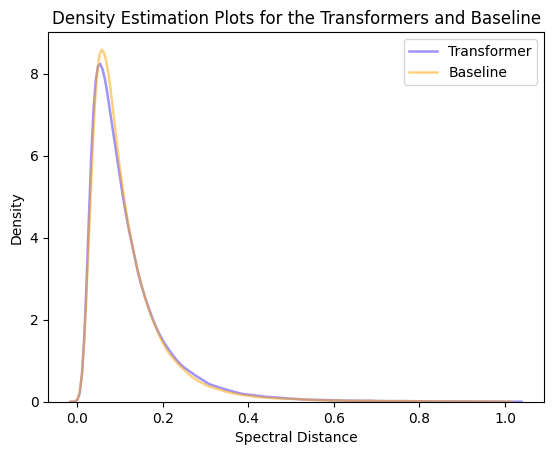

In [19]:
prosit_transformer_eval.kde_per_model(
    df,
    ["Transformer_loss", "Baseline_loss", "TransformerSmall_loss"],
    title="Density Estimation Plots for the Transformers and Baseline",
    xaxis_title="Spectral Distance",
    yaxis_title="Density",
#     colors=["#4028ff","#f8a500", "#288f3b"],
    alpha=0.5,
    fill=False,
    linewidth=1.8
)